##### Copyright 2018 The TensorFlow Authors.

In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [2]:
# TensorFlow
import tensorflow as tf

# TensorFlow Datsets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from os import getcwd

print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.0.0
• GPU Device Found.


# Download Fashion MNIST Dataset

We will use TensorFlow Datasets to load the Fashion MNIST dataset. 

In [3]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

filePath = f"{getcwd()}/../tmp2/"
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits, data_dir=filePath)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

The class names are not included with the dataset, so we will specify them here.

In [4]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [6]:
# The images in the dataset are 28 by 28 pixels.
IMG_SIZE = 28

# Preprocessing Data

## Preprocess

In [7]:
# EXERCISE: Write a function to normalize the images.

def format_example(image, label):
    # Cast image to float32
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)   
      
    # Normalize the image in the range [0, 1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    
    return image, label

In [8]:
# Specify the batch size
BATCH_SIZE = 256

## Create Datasets From Images and Labels

In [9]:
# Create Datasets
train_batches = train_examples.shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.map(format_example).batch(1)

# Building the Model

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
```

In [10]:
# EXERCISE: Build and compile the model shown in the previous cell.

model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=3, filters=16, activation='relu'),
      
    tf.keras.layers.MaxPooling2D(),
      
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, activation='relu'),
      
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
      
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),
      
    # Attach a final softmax classification head
    tf.keras.layers.Dense(10, activation='softmax')])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train

In [11]:
history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

Epoch 1/10
219/219 [==============================] - 209s 955ms/step - loss: 1.4987 - accuracy: 0.4832 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
219/219 [==============================] - 209s 957ms/step - loss: 0.7653 - accuracy: 0.7153 - val_loss: 0.6910 - val_accuracy: 0.7363
Epoch 3/10
219/219 [==============================] - 206s 942ms/step - loss: 0.6645 - accuracy: 0.7475 - val_loss: 0.6322 - val_accuracy: 0.7583
Epoch 4/10
219/219 [==============================] - 203s 929ms/step - loss: 0.6113 - accuracy: 0.7664 - val_loss: 0.5764 - val_accuracy: 0.7841
Epoch 5/10
219/219 [==============================] - 223s 1s/step - loss: 0.5768 - accuracy: 0.7822 - val_loss: 0.5532 - val_accuracy: 0.7961
Epoch 6/10
219/219 [==============================] - 193s 881ms/step - loss: 0.5522 - accuracy: 0.7921 - val_loss: 0.5382 - val_accuracy: 0.8037
Epoch 7/10
219/219 [==============================] - 158s 721ms/step - loss: 0.5320 - accuracy: 0.8002 - val_loss: 0.5

# Exporting to TFLite

You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 

In [16]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [17]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [19]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [20]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

258656

# Test the Model with TFLite Interpreter 

In [21]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [22]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

In [23]:
# Utilities functions for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

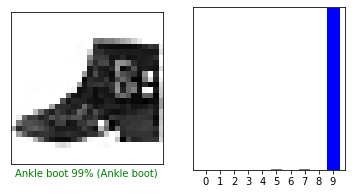

In [24]:
# Visualize the outputs

# Select index of image to display. Minimum index value is 1 and max index value is 50. 
index = 49 

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(index, predictions, test_labels)
plt.show()

# Click the Submit Assignment Button Above

You should now click the Submit Assignment button above to submit your notebook for grading. Once you have submitted your assignment, you can continue with the optinal section below. 

## If you are done, please **don't forget to run the last two cells of this notebook** to save your work and close the Notebook to free up resources for your fellow learners. 

# Prepare the Test Images for Download (Optional)

In [25]:
!mkdir -p test_images

In [26]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [27]:
!ls test_images

'ankle boot_13.jpg'   coat_42.jpg       sandal_17.jpg	 sneaker_22.jpg
'ankle boot_16.jpg'   coat_8.jpg        sandal_20.jpg	 sneaker_31.jpg
'ankle boot_18.jpg'   dress_1.jpg       sandal_28.jpg	 sneaker_37.jpg
'ankle boot_49.jpg'   dress_11.jpg      sandal_32.jpg	 sneaker_40.jpg
 bag_15.jpg	      dress_12.jpg      sandal_47.jpg	 sneaker_44.jpg
 bag_24.jpg	      dress_21.jpg      shirt_3.jpg	 t-shirt_top_41.jpg
 bag_25.jpg	      dress_45.jpg      shirt_33.jpg	 t-shirt_top_43.jpg
 bag_29.jpg	      dress_46.jpg      shirt_38.jpg	 trouser_0.jpg
 bag_34.jpg	      pullover_23.jpg   shirt_4.jpg	 trouser_14.jpg
 bag_5.jpg	      pullover_26.jpg   shirt_6.jpg	 trouser_2.jpg
 bag_7.jpg	      pullover_36.jpg   shirt_9.jpg	 trouser_30.jpg
 coat_27.jpg	      pullover_39.jpg   sneaker_10.jpg
 coat_35.jpg	      pullover_48.jpg   sneaker_19.jpg


In [28]:
!tar --create --file=fmnist_test_images.tar test_images

In [29]:
!ls

Exercise_1_TF_Lite_Question-FINAL.ipynb  labels.txt    saved_model
fmnist_test_images.tar			 model.tflite  test_images


# When you're done/would like to take a break, please run the two cells below to save your work and close the Notebook. This frees up resources for your fellow learners.